https://www.tensorflow.org/tutorials/text/word_embeddings

# 单词嵌入向量
### 从头开始学习嵌入向量
在本教程中，您将基于 IMDB 电影评论来训练情感分类器。在此过程中，模型将从头开始学习嵌入向量。我们将使用经过预处理的数据集。

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST), 
                                          with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJL73E3/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJL73E3/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJL73E3/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


获取编码器 (tfds.features.text.SubwordTextEncoder)，并快速浏览词汇表。

词汇表中的“”代表空格。请注意词汇表如何包含完整单词（以“”结尾）以及可用于构建更大单词的部分单词：

In [3]:
encoder = info.features['text'].encoder
print(encoder.subwords[:20])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


In [4]:
#电影评论的长度可以不同。我们将使用 padded_batch 方法来标准化评论的长度。
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

导入时，评论的文本是整数编码的（每个整数代表词汇表中的特定单词或单词部分）。

请注意尾随零，因为批次会填充为最长的示例。

In [9]:
train_batch, train_labels = next(iter(train_batches))
print(train_batch.numpy())
print(train_batch.shape)

[[ 249    4 7510 ...    0    0    0]
 [  62    9 3037 ...    0    0    0]
 [  19  651 3966 ...    0    0    0]
 ...
 [  12  548 7968 ... 7961 2679 5245]
 [  12   81  174 ...    0    0    0]
 [ 249   41 6894 ...    0    0    0]]
(10, 365)


# 创建一个简单模型
我们将使用 Keras 序列式 API 定义模型。在这种情况下，它是一个“连续词袋”样式的模型。

* 接下来，嵌入向量层将采用整数编码的词汇表，并查找每个单词索引的嵌入向量。在模型训练时会学习这些向量。向量会向输出数组添加维度。得到的维度为：(batch, sequence, embedding)。

* 接下来，通过对序列维度求平均值，GlobalAveragePooling1D 层会返回每个样本的固定长度输出向量。这让模型能够以最简单的方式处理可变长度的输入。

* 此固定长度输出向量通过一个包含 16 个隐藏单元的完全连接（密集）层进行流水线传输。

* 最后一层与单个输出节点密集连接。利用 Sigmoid 激活函数，得出此值是 0 到 1 之间的浮点数，表示评论为正面的概率（或置信度）。

In [10]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


# 编译和训练模型

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6169 - accuracy: 0.5761 - val_loss: 0.3852 - val_accuracy: 0.8500
Epoch 2/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3102 - accuracy: 0.8696 - val_loss: 0.4095 - val_accuracy: 0.7950
Epoch 3/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2441 - accuracy: 0.9011 - val_loss: 0.2625 - val_accuracy: 0.9100
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2068 - accuracy: 0.9190 - val_loss: 0.3173 - val_accuracy: 0.8600
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1834 - accuracy: 0.9304 - val_loss: 0.3964 - val_accuracy: 0.8600
Epoch 6/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.1635 - accuracy: 0.9387 - val_loss: 0.2947 - val_accuracy: 0.8700
Epoch 7/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.1484 - accuracy: 0.9446 - val_loss: 0.4071 - val_accuracy

通过这种方法，我们的模型可以达到约 88% 的验证准确率（请注意，该模型过度拟合，因此训练准确率要高得多）。

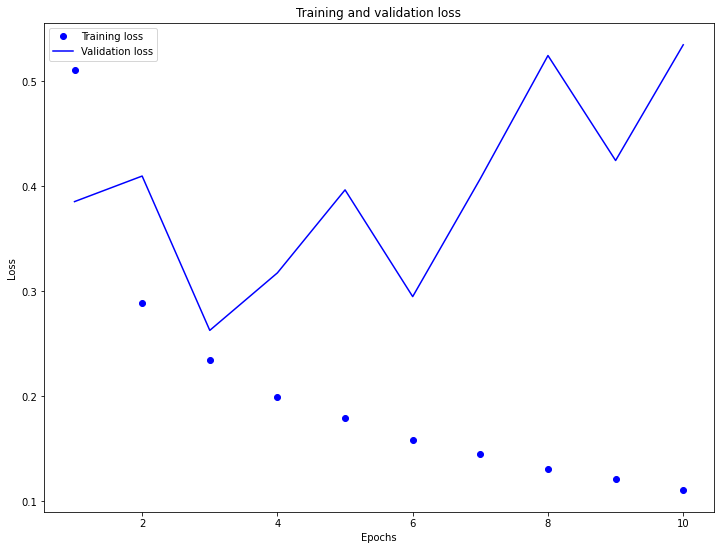

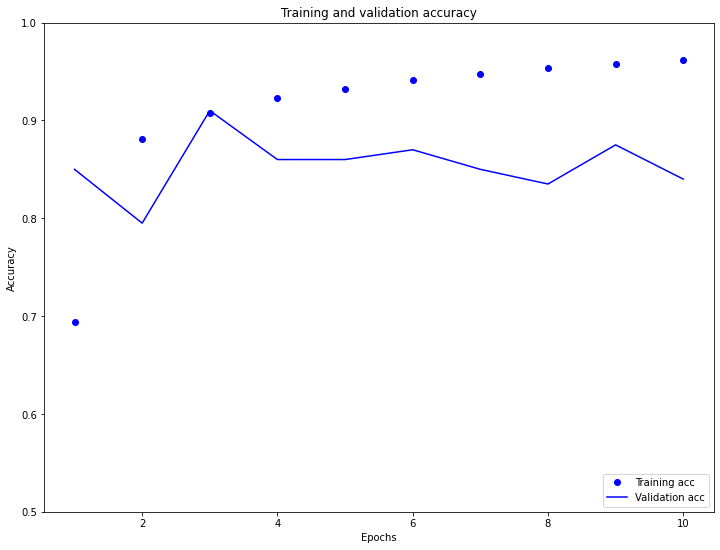

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

# 检索学习的嵌入向量
接下来，我们检索在训练期间学习的单词嵌入向量。这将是一个形状为 (vocab_size, embedding-dimension) 的矩阵。

In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


现在，我们将权重写入磁盘。要使用 Embedding Projector，我们将以制表符分隔的格式上传两个文件：一个向量文件（包含嵌入向量）和一个元数据文件（包含单词）。

In [14]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# 可视化嵌入向量
为了可视化嵌入向量，我们将它们上传到 Embedding Projector。

打开 Embedding Projector（也可以在本地 TensorBoard 实例中运行）。

* 点击“Load data”。

* 上传我们在上面创建的两个文件：vecs.tsv 和 meta.tsv。

现在将显示您已训练的嵌入向量。您可以搜索单词以查找其最邻近。例如，尝试搜索“beautiful”，您可能会看到“wonderful”等相邻单词。

注：您的结果可能会略有不同，具体取决于训练嵌入向量层之前如何随机初始化权重。

注：您可以试验性地使用更简单的模型来生成更多可解释的嵌入向量。尝试删除 Dense(16) 层，重新训练模型，然后再次可视化嵌入向量。